In [1]:
import pandas as pd
import numpy as np
from os.path import basename
from glob import glob
import h5py

import scipy.stats as ss
from sklearn.metrics import r2_score, average_precision_score, roc_auc_score

import matplotlib.pyplot as plt
from plotnine import *
from IPython.display import display, Markdown

import sys
sys.path.insert(0, '../CODE/')
from importlib import reload
import visualization_utils
reload(visualization_utils)
from visualization_utils import *

import warnings
warnings.filterwarnings('ignore')

import shap

# Recreate AuPRC vs |log2 FC| plot

### Mapping tables from HGNC to ENSEMBL vice-versa

In [2]:
# ENSEMBL --> HGNC MAPPING
human_name_dict = {
    row['ENSEMBL']: row['HGNC'] \
    for _, row in pd.read_csv(
        '../RESOURCES/induction/hgnc_ensembl.tbl',
        sep='\t'
    ).iterrows()}

# HGNC --> ENSEMBL MAPPING
ensembl_name_dict = {
    row['HGNC']: row['ENSEMBL'] \
    for _, row in pd.read_csv(
        '../RESOURCES/induction/hgnc_ensembl.tbl',
        sep='\t'
    ).iterrows()}

## LOAD DATA

In [3]:
algo = 'xgb'
feat_types = ['all_feats']
dirpath = '../OUTPUT/Human_chip_pert_enhanPromo500kbAgg_5primPromo2kb_CPU'

### STATS (stats.csv.gz)

In [4]:
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)

... working on all_feats
ENSG00000074219
ENSG00000115816
ENSG00000144161
ENSG00000141568
ENSG00000105698
ENSG00000172273
ENSG00000198176
ENSG00000162772
ENSG00000143390
ENSG00000001167
ENSG00000197905
ENSG00000143379
ENSG00000158773
ENSG00000147421
ENSG00000134138
ENSG00000179348
ENSG00000131931
ENSG00000177463
ENSG00000187098
ENSG00000123358
ENSG00000173039
ENSG00000106459
ENSG00000102145
ENSG00000185551
ENSG00000130522
ENSG00000082641
ENSG00000060138
ENSG00000177485
ENSG00000105722
ENSG00000111206
ENSG00000112658
ENSG00000126746
ENSG00000186918
ENSG00000130254
ENSG00000113658
ENSG00000177045
ENSG00000156273
ENSG00000166478
ENSG00000126561
ENSG00000160633
ENSG00000120837
ENSG00000185591


## INPUT FILE (perturbation response)

In [5]:
# read input file
df = pd.read_csv('../RESOURCES/HumanK562_TFPert/K562_pertResp_DESeq2_long.csv', sep=',')
print("shape: ", df.shape)
df.head()

shape:  (1104768, 5)


,tf_hgnc,tf_ensg,gene_ensg,log2FoldChange,padj
0,ARID3A,ENSG00000116017,ENSG00000000003,-0.013423,0.999934
1,ARID3A,ENSG00000116017,ENSG00000000005,0.005889,0.999934
2,ARID3A,ENSG00000116017,ENSG00000000419,0.015190,0.999934
3,ARID3A,ENSG00000116017,ENSG00000000457,-0.024851,0.999934
4,ARID3A,ENSG00000116017,ENSG00000000460,-0.002384,0.999934


In [20]:
all_tfs = [tf for tf in df['tf_ensg'].unique()]
print(len(all_tfs))
all_tfs

42


['ENSG00000162772',
 'ENSG00000156273',
 'ENSG00000115816',
 'ENSG00000105722',
 'ENSG00000141568',
 'ENSG00000111206',
 'ENSG00000102145',
 'ENSG00000179348',
 'ENSG00000172273',
 'ENSG00000147421',
 'ENSG00000130522',
 'ENSG00000134138',
 'ENSG00000187098',
 'ENSG00000082641',
 'ENSG00000001167',
 'ENSG00000120837',
 'ENSG00000177463',
 'ENSG00000185551',
 'ENSG00000123358',
 'ENSG00000106459',
 'ENSG00000173039',
 'ENSG00000143390',
 'ENSG00000130254',
 'ENSG00000160633',
 'ENSG00000143379',
 'ENSG00000177045',
 'ENSG00000113658',
 'ENSG00000185591',
 'ENSG00000112658',
 'ENSG00000126561',
 'ENSG00000074219',
 'ENSG00000197905',
 'ENSG00000198176',
 'ENSG00000131931',
 'ENSG00000158773',
 'ENSG00000105698',
 'ENSG00000060138',
 'ENSG00000177485',
 'ENSG00000144161',
 'ENSG00000166478',
 'ENSG00000126746',
 'ENSG00000186918']

In [6]:
# list of trained TF models
subdirs = glob('{}/{}/{}/*'.format(dirpath, 'all_feats', 'xgb'))
subdirs = [basename(subdir) for subdir in subdirs]
print('{} trained models'.format(len(subdirs)))

# take subset of TFs that we have binding locations data of
df = df[df['tf_ensg'].isin(subdirs)]
df

42 trained models


,tf_hgnc,tf_ensg,gene_ensg,log2FoldChange,padj
19728,ATF3,ENSG00000162772,ENSG00000186652,-1.227364,1.561967e-49
19729,ATF3,ENSG00000162772,ENSG00000110876,-1.402234,3.473520e-49
19730,ATF3,ENSG00000162772,ENSG00000117984,-0.766997,1.920930e-39
19731,ATF3,ENSG00000162772,ENSG00000161011,-0.788784,3.539923e-38
19732,ATF3,ENSG00000162772,ENSG00000030582,-0.817537,4.903445e-38
...,...,...,...,...,...
1104763,ZNF395,ENSG00000186918,ENSG00000282936,0.120622,1.000000e+00
1104764,ZNF395,ENSG00000186918,ENSG00000283039,0.255575,1.000000e+00
1104765,ZNF395,ENSG00000186918,ENSG00000283071,0.017016,1.000000e+00
1104766,ZNF395,ENSG00000186918,ENSG00000283088,0.000000,1.000000e+00


## extract AUPRC

In [7]:
# extract AuPRC (mean)
mean_auprc = stats.groupby(['tf_com'])[['auprc']].mean().reset_index()
mean_auprc['tf'] = mean_auprc['tf_com'].map(ensembl_name_dict) # new column with ensembl IDs
mean_auprc

,tf_com,auprc,tf
0,ATF3,0.193059,ENSG00000162772
1,BACH1,0.014722,ENSG00000156273
2,CEBPZ,0.134350,ENSG00000115816
3,ERF,0.420727,ENSG00000105722
4,FOXK2,0.261068,ENSG00000141568
5,FOXM1,0.515952,ENSG00000111206
6,GATA1,0.248864,ENSG00000102145
7,GATA2,0.103174,ENSG00000179348
8,HINFP,0.109642,ENSG00000172273
9,HMBOX1,0.018676,ENSG00000147421


### Compute |log2 FC|

In [8]:
# absfc = 2^|l2fc|
df_absl2fc = df.copy()
df_absl2fc['fc'] = df_absl2fc.apply(lambda row : 2**abs(row['log2FoldChange']), axis=1)

# absl2fc = log2 ( 2^|l2fc|)
df_absl2fc['absl2fc'] = df_absl2fc.apply(lambda row : np.log2(row['fc']), axis=1)
df_absl2fc

,tf_hgnc,tf_ensg,gene_ensg,log2FoldChange,padj,fc,absl2fc
19728,ATF3,ENSG00000162772,ENSG00000186652,-1.227364,1.561967e-49,2.341388,1.227364
19729,ATF3,ENSG00000162772,ENSG00000110876,-1.402234,3.473520e-49,2.643106,1.402234
19730,ATF3,ENSG00000162772,ENSG00000117984,-0.766997,1.920930e-39,1.701724,0.766997
19731,ATF3,ENSG00000162772,ENSG00000161011,-0.788784,3.539923e-38,1.727617,0.788784
19732,ATF3,ENSG00000162772,ENSG00000030582,-0.817537,4.903445e-38,1.762395,0.817537
...,...,...,...,...,...,...,...
1104763,ZNF395,ENSG00000186918,ENSG00000282936,0.120622,1.000000e+00,1.087204,0.120622
1104764,ZNF395,ENSG00000186918,ENSG00000283039,0.255575,1.000000e+00,1.193811,0.255575
1104765,ZNF395,ENSG00000186918,ENSG00000283071,0.017016,1.000000e+00,1.011864,0.017016
1104766,ZNF395,ENSG00000186918,ENSG00000283088,0.000000,1.000000e+00,1.000000,0.000000


In [9]:
# grab rows where the perturbed Tf == target gene
df_tfs = df_absl2fc.query('tf_ensg == gene_ensg').reset_index(drop=True)

# join with mean_auprc
df_tfs = df_tfs.set_index('tf_ensg').join(mean_auprc[['tf','auprc']].set_index('tf'))
df_tfs

,tf_hgnc,gene_ensg,log2FoldChange,padj,fc,absl2fc,auprc
tf_ensg,,,,,,,
ENSG00000162772,ATF3,ENSG00000162772,-1.219755,3.813001e-09,2.329071,1.219755,0.193059
ENSG00000156273,BACH1,ENSG00000156273,-0.950358,3.643116e-17,1.932352,0.950358,0.014722
ENSG00000115816,CEBPZ,ENSG00000115816,-0.302977,1.646301e-02,1.233687,0.302977,0.134350
ENSG00000105722,ERF,ENSG00000105722,-0.977160,4.160376e-19,1.968586,0.977160,0.420727
ENSG00000141568,FOXK2,ENSG00000141568,-0.485458,2.097228e-11,1.400031,0.485458,0.261068
ENSG00000111206,FOXM1,ENSG00000111206,-0.292134,1.735259e-02,1.224451,0.292134,0.515952
ENSG00000102145,GATA1,ENSG00000102145,-0.971694,2.549739e-04,1.961142,0.971694,0.248864
ENSG00000179348,GATA2,ENSG00000179348,-0.313663,2.128164e-03,1.242859,0.313663,0.103174
ENSG00000172273,HINFP,ENSG00000172273,-0.416324,1.657782e-01,1.334523,0.416324,0.109642


In [10]:
# tf name, absl2fc, auprc
df_tfs_simp = df_tfs[['tf_hgnc','absl2fc','auprc']]
df_tfs_simp

,tf_hgnc,absl2fc,auprc
tf_ensg,,,
ENSG00000162772,ATF3,1.219755,0.193059
ENSG00000156273,BACH1,0.950358,0.014722
ENSG00000115816,CEBPZ,0.302977,0.134350
ENSG00000105722,ERF,0.977160,0.420727
ENSG00000141568,FOXK2,0.485458,0.261068
ENSG00000111206,FOXM1,0.292134,0.515952
ENSG00000102145,GATA1,0.971694,0.248864
ENSG00000179348,GATA2,0.313663,0.103174
ENSG00000172273,HINFP,0.416324,0.109642


## Plot

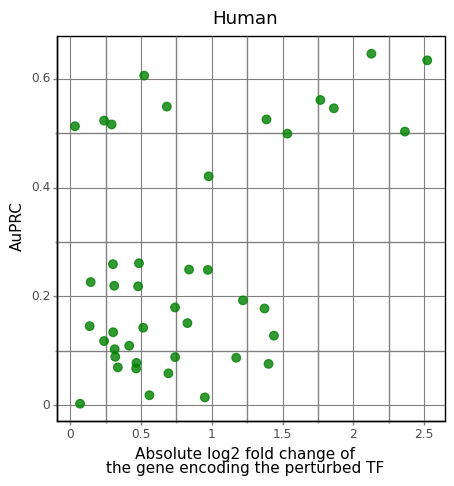

<ggplot: (-9223363248422885565)>

In [11]:
# plot the auprc by absl2fc
theme_set(theme_bw())
gp = (ggplot(df_tfs_simp,
      aes(x='absl2fc', y='auprc'))
    
      + geom_point(alpha=0.8, color='green',size=3)
      
      + labs(title='Human',
             x='Absolute log2 fold change of\nthe gene encoding the perturbed TF',
             y='AuPRC')
      
      + theme_bw() +
        theme(line=element_line(color="gray"),
              axis_line=element_line(color="black"),
              axis_ticks=element_line(color = "black"),
              figure_size=(5,5),
              panel_border=element_line(color="black"))
     )

gp

In [53]:
# keep "responsive" target rows only (absl2fc > 0.5 AND padj < 0.05) for our select TF (USF2)
responsive_targets_df = df_absl2fc[df_absl2fc['tf_ensg'].isin(all_tfs)] # select TF 
print(responsive_targets_df.shape)
print(responsive_targets_df['gene_ensg'].nunique())
responsive_targets_df = responsive_targets_df[(responsive_targets_df['absl2fc'] > 0.5) & (responsive_targets_df['padj'] < 0.05)].reset_index(drop=True)
responsive_targets_df

(828576, 7)
19728


,tf_hgnc,tf_ensg,gene_ensg,log2FoldChange,padj,fc,absl2fc
0,ATF3,ENSG00000162772,ENSG00000186652,-1.227364,1.561967e-49,2.341388,1.227364
1,ATF3,ENSG00000162772,ENSG00000110876,-1.402234,3.473520e-49,2.643106,1.402234
2,ATF3,ENSG00000162772,ENSG00000117984,-0.766997,1.920930e-39,1.701724,0.766997
3,ATF3,ENSG00000162772,ENSG00000161011,-0.788784,3.539923e-38,1.727617,0.788784
4,ATF3,ENSG00000162772,ENSG00000030582,-0.817537,4.903445e-38,1.762395,0.817537
...,...,...,...,...,...,...,...
64820,ZNF395,ENSG00000186918,ENSG00000103490,-0.573476,3.984365e-02,1.488104,0.573476
64821,ZNF395,ENSG00000186918,ENSG00000196878,-0.580671,4.031915e-02,1.495545,0.580671
64822,ZNF395,ENSG00000186918,ENSG00000005379,-0.565933,4.206661e-02,1.480344,0.565933
64823,ZNF395,ENSG00000186918,ENSG00000185900,0.566568,4.758024e-02,1.480996,0.566568


# LOAD DATA

## MODEL INPUT

### SHAP VALUES (`shapd_df`)

In [21]:
shaps_df = parse_classifier_shap(dirpath, all_tfs, algo, 'all_feats', human_name_dict)
shaps_df

['ENSG00000162772', 'ENSG00000156273', 'ENSG00000115816', 'ENSG00000105722', 'ENSG00000141568', 'ENSG00000111206', 'ENSG00000102145', 'ENSG00000179348', 'ENSG00000172273', 'ENSG00000147421', 'ENSG00000130522', 'ENSG00000134138', 'ENSG00000187098', 'ENSG00000082641', 'ENSG00000001167', 'ENSG00000120837', 'ENSG00000177463', 'ENSG00000185551', 'ENSG00000123358', 'ENSG00000106459', 'ENSG00000173039', 'ENSG00000143390', 'ENSG00000130254', 'ENSG00000160633', 'ENSG00000143379', 'ENSG00000177045', 'ENSG00000113658', 'ENSG00000185591', 'ENSG00000112658', 'ENSG00000126561', 'ENSG00000074219', 'ENSG00000197905', 'ENSG00000198176', 'ENSG00000131931', 'ENSG00000158773', 'ENSG00000105698', 'ENSG00000060138', 'ENSG00000177485', 'ENSG00000144161', 'ENSG00000166478', 'ENSG00000126746', 'ENSG00000186918']
ENSG00000074219
ENSG00000115816
ENSG00000144161
ENSG00000141568
ENSG00000105698
ENSG00000172273
ENSG00000198176
ENSG00000162772
ENSG00000143390
ENSG00000001167
ENSG00000197905
ENSG00000143379
ENSG00000

,tf,gene,feat_idx,feat,cv
0,ENSG00000074219,ENSG00000000971,0,0.000000,0
1,ENSG00000074219,ENSG00000001167,0,0.000000,0
2,ENSG00000074219,ENSG00000002330,0,0.000000,0
3,ENSG00000074219,ENSG00000002586,0,0.000000,0
4,ENSG00000074219,ENSG00000002933,0,0.000000,0
...,...,...,...,...,...
276797803,ENSG00000185591,ENSG00000278845,347,-0.440655,9
276797804,ENSG00000185591,ENSG00000278848,347,-0.061283,9
276797805,ENSG00000185591,ENSG00000278889,347,-0.294521,9
276797806,ENSG00000185591,ENSG00000280670,347,-0.621952,9


### FEATURE MATRIX (`feat_mtx_df`) of significant TFs

In [26]:
# feature matrix for single TF
feat_mtx_df = parse_classifier_feat(dirpath, all_tfs, algo, 'all_feats', human_name_dict)
feat_mtx_df

['ENSG00000162772', 'ENSG00000156273', 'ENSG00000115816', 'ENSG00000105722', 'ENSG00000141568', 'ENSG00000111206', 'ENSG00000102145', 'ENSG00000179348', 'ENSG00000172273', 'ENSG00000147421', 'ENSG00000130522', 'ENSG00000134138', 'ENSG00000187098', 'ENSG00000082641', 'ENSG00000001167', 'ENSG00000120837', 'ENSG00000177463', 'ENSG00000185551', 'ENSG00000123358', 'ENSG00000106459', 'ENSG00000173039', 'ENSG00000143390', 'ENSG00000130254', 'ENSG00000160633', 'ENSG00000143379', 'ENSG00000177045', 'ENSG00000113658', 'ENSG00000185591', 'ENSG00000112658', 'ENSG00000126561', 'ENSG00000074219', 'ENSG00000197905', 'ENSG00000198176', 'ENSG00000131931', 'ENSG00000158773', 'ENSG00000105698', 'ENSG00000060138', 'ENSG00000177485', 'ENSG00000144161', 'ENSG00000166478', 'ENSG00000126746', 'ENSG00000186918']
(0, 1052)
ENSG00000074219
(18938, 1052)
ENSG00000115816
(18938, 1052)
ENSG00000144161
(18938, 1052)
ENSG00000141568
(18938, 1052)
ENSG00000105698
(18938, 1052)
ENSG00000172273
(18938, 1052)
ENSG0000019

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat1042,feat1043,feat1044,feat1045,feat1046,feat1047,feat1048,feat1049,feat1050,feat1051
0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795391,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
795392,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
795393,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
795394,0.0,0.0,0.0,0.0,0.47206,0.761387,0.761387,0.761387,0.761387,0.060911,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### PREDICTIONS (`preds_df`)

In [23]:
file = '../OUTPUT/Human_chip_pert_enhanPromo500kbAgg_5primPromo2kb_CPU/all_feats/xgb/ENSG00000105698/preds.csv.gz'
preds_df = pd.read_csv(file, header=0)
preds_df

,gene,cv,label,pred
0,ENSG00000000005,0,0,0.043280
1,ENSG00000000457,0,0,0.100679
2,ENSG00000000460,0,1,0.311293
3,ENSG00000002587,0,1,0.139980
4,ENSG00000003137,0,1,0.306976
...,...,...,...,...
18933,ENSG00000276600,9,0,0.167731
18934,ENSG00000277972,9,0,0.597258
18935,ENSG00000278540,9,0,0.225301
18936,ENSG00000278677,9,0,0.448953


### LIST OF GENES (`genes_df`)

In [25]:
def compare_gene_list(tfs, dirpath):
    genes_list = []
    
    for tf in tfs:
        file = '{}/{}/genes.csv.gz'.format(dirpath,tf)
        
        genes_df = pd.read_csv(file, header=None, names=['gene'])
        genes_list.append(genes_df)
        
    for i in range(len(genes_list)-1):
        assert genes_list[i].equals(genes_list[i+1])
        
    print('all gene lists are equal!')
        
compare_gene_list(all_tfs, '../OUTPUT/Human_chip_pert_enhanPromo500kbAgg_5primPromo2kb_CPU/all_feats/xgb')

all gene lists are equal!


In [24]:
file = '../OUTPUT/Human_chip_pert_enhanPromo500kbAgg_5primPromo2kb_CPU/all_feats/xgb/{}/genes.csv.gz'.format(all_tfs[0])
genes_df = pd.read_csv(file, header=None, names=['gene'])
genes_df

,gene
0,ENSG00000000003
1,ENSG00000000005
2,ENSG00000000419
3,ENSG00000000457
4,ENSG00000000460
...,...
18933,ENSG00000282419
18934,ENSG00000282608
18935,ENSG00000282815
18936,ENSG00000282872


## PROCESSING

### join `feat_mtx_df` with `genes_df`

In [29]:
genes_df

,gene
0,ENSG00000000003
1,ENSG00000000005
2,ENSG00000000419
3,ENSG00000000457
4,ENSG00000000460
...,...
18933,ENSG00000282419
18934,ENSG00000282608
18935,ENSG00000282815
18936,ENSG00000282872


In [28]:
feat_mtx_df

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat1042,feat1043,feat1044,feat1045,feat1046,feat1047,feat1048,feat1049,feat1050,feat1051
0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795391,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
795392,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
795393,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
795394,0.0,0.0,0.0,0.0,0.47206,0.761387,0.761387,0.761387,0.761387,0.060911,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# add respective genes to feature matrix
feat_mtx_resp_df = feat_mtx_df.copy()
feat_mtx_resp_df.index = len(all_tfs)*genes_df['gene'].tolist()

## Remove non-responsive genes

We are averaging over responsive target genes so remove shap values for target genes that are not responsive (l2fc < 0.5 or p-val > 0.05)

In [55]:
# remove non-responsive genes
feat_mtx_resp_df = feat_mtx_resp_df[feat_mtx_resp_df.index.isin(responsive_targets_df['gene_ensg'])]
feat_mtx_resp_df

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat1042,feat1043,feat1044,feat1045,feat1046,feat1047,feat1048,feat1049,feat1050,feat1051
ENSG00000000419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000000460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000000938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000000971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000001617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000280670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000280789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000281991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000282419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### AVERAGE SHAP VALUES FOR FEATURES OVER RESPONSIVE TARGET GENES

In [33]:
shap_sigtfs_df = shaps_df[shaps_df['tf'].isin(all_tfs)] # grab shap data for significant TFs
shap_sigtfs_df

,tf,gene,feat_idx,feat,cv
0,ENSG00000074219,ENSG00000000971,0,0.000000,0
1,ENSG00000074219,ENSG00000001167,0,0.000000,0
2,ENSG00000074219,ENSG00000002330,0,0.000000,0
3,ENSG00000074219,ENSG00000002586,0,0.000000,0
4,ENSG00000074219,ENSG00000002933,0,0.000000,0
...,...,...,...,...,...
276797803,ENSG00000185591,ENSG00000278845,347,-0.440655,9
276797804,ENSG00000185591,ENSG00000278848,347,-0.061283,9
276797805,ENSG00000185591,ENSG00000278889,347,-0.294521,9
276797806,ENSG00000185591,ENSG00000280670,347,-0.621952,9


In [56]:
# subset of responsive target genes
shap_sigtfs_resp_df = shap_sigtfs_df[shap_sigtfs_df['gene'].isin(responsive_targets_df['gene_ensg'])].reset_index(drop=True)
shap_sigtfs_resp_df

,tf,gene,feat_idx,feat,cv
0,ENSG00000074219,ENSG00000000971,0,0.000000,0
1,ENSG00000074219,ENSG00000001167,0,0.000000,0
2,ENSG00000074219,ENSG00000002330,0,0.000000,0
3,ENSG00000074219,ENSG00000002586,0,0.000000,0
4,ENSG00000074219,ENSG00000004455,0,0.000000,0
...,...,...,...,...,...
146920027,ENSG00000185591,ENSG00000276600,347,-0.224681,9
146920028,ENSG00000185591,ENSG00000277161,347,0.194626,9
146920029,ENSG00000185591,ENSG00000277224,347,0.730819,9
146920030,ENSG00000185591,ENSG00000280670,347,-0.621952,9


In [57]:
shap_sigtfs_df['feat_idx'].nunique()

348

In [58]:
shap_sigtfs_resp_df['feat_idx'].nunique()

348

Take the mean of the shap values for each perturbed TF (over the responsive genes)

In [59]:
# unstack and average
shap_sigtfs_mean_resp_df = shap_sigtfs_resp_df[['tf','gene','feat_idx','feat','cv']]
shap_sigtfs_mean_resp_df = shap_sigtfs_mean_resp_df.groupby(['tf','feat_idx'], as_index=False)[['feat']].mean()
shap_sigtfs_mean_resp_df

,tf,feat_idx,feat
0,ENSG00000001167,0,0.000000
1,ENSG00000001167,1,0.000000
2,ENSG00000001167,2,0.000000
3,ENSG00000001167,3,0.000000
4,ENSG00000001167,4,0.000000
...,...,...,...
14611,ENSG00000198176,343,0.000032
14612,ENSG00000198176,344,0.000866
14613,ENSG00000198176,345,0.004585
14614,ENSG00000198176,346,0.759218


In [60]:
# def subset_responsive(shap_df, resp_genes, sig_tfs):
    
#     out_df = pd.DataFrame(columns=shap_df.columns)
    
#     for tf in sig_tfs:
        
#         shap_tf = shap_df[shap_df['tf'] == tf]
#         shap_tf = shap_tf[shap_tf['gene'].isin(resp_genes)].reset_index()
        
#         out_df.append(shap_tf, ignore_index=True)
        
#     return out_df

# shap_sig_tfs_mean_resp_df = subset_responsive(shap_sigtfs_mean_df, responsive_targets_df['gene_ensg'], sig_tfs)
# shap_sig_tfs_mean_resp_df

In [61]:
# pivot
shap_sigtfs_mean_resp_df = shap_sigtfs_mean_resp_df.pivot(index='tf', columns='feat_idx', values='feat')
shap_sigtfs_mean_resp_df

feat_idx,0,1,2,3,4,5,6,7,8,9,...,338,339,340,341,342,343,344,345,346,347
tf,,,,,,,,,,,,,,,,,,,,,
ENSG00000001167,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,-1.593626e-05,1.495502e-06,-0.000006,0.006823,-0.010464,-0.000033,-2.292926e-04,0.047907,0.159313,-0.007130
ENSG00000060138,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,-2.935836e-03,-0.002106,0.000000,-0.008988,-0.002011,-1.126266e-04,-0.000152,0.429059,-0.018706
ENSG00000074219,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,5.257284e-05,6.705177e-04,0.000037,0.000954,0.014611,0.001750,8.878168e-04,0.003976,0.822830,0.108526
ENSG00000082641,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,-3.293183e-04,-1.439017e-03,-0.000042,0.007785,-0.017396,-0.000722,-5.169765e-04,0.013138,0.142260,0.009074
ENSG00000102145,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,-1.131407e-05,2.532093e-03,0.000027,0.001219,-0.019153,-0.000122,-1.362563e-05,0.002100,0.454543,0.034278
ENSG00000105698,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.100035e-05,2.125200e-03,-0.000050,0.022134,0.026889,0.000056,5.241183e-03,0.054952,0.241678,0.122802
ENSG00000105722,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.024636e-04,2.200293e-04,-0.000075,0.001437,0.000061,-0.000187,2.174644e-04,0.005531,0.786628,0.065128
ENSG00000106459,0.000000e+00,0.000000,0.000000e+00,0.000027,-2.548130e-05,0.000676,1.368936e-05,-0.000327,-0.000001,0.000000,...,2.792845e-05,-1.545863e-04,0.000021,-0.000004,-0.003562,0.000008,-1.027929e-04,0.001681,0.239254,-0.025278
ENSG00000111206,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,7.887136e-05,3.922412e-03,-0.000137,0.015056,0.000245,0.000006,3.001202e-03,0.021460,0.593039,0.094704


In [62]:
# rename columns from i --> feati
shap_sigtfs_mean_resp_df.columns = ['feat{}'.format(i) for i in shap_sigtfs_mean_resp_df.columns]
shap_sigtfs_mean_resp_df = shap_sigtfs_mean_resp_df.reset_index(drop=True) # remove index (gene names)

shap_sigtfs_mean_resp_df

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat338,feat339,feat340,feat341,feat342,feat343,feat344,feat345,feat346,feat347
0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,-1.593626e-05,1.495502e-06,-0.000006,0.006823,-0.010464,-0.000033,-2.292926e-04,0.047907,0.159313,-0.007130
1,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,-2.935836e-03,-0.002106,0.000000,-0.008988,-0.002011,-1.126266e-04,-0.000152,0.429059,-0.018706
2,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,5.257284e-05,6.705177e-04,0.000037,0.000954,0.014611,0.001750,8.878168e-04,0.003976,0.822830,0.108526
3,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,-3.293183e-04,-1.439017e-03,-0.000042,0.007785,-0.017396,-0.000722,-5.169765e-04,0.013138,0.142260,0.009074
4,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,-1.131407e-05,2.532093e-03,0.000027,0.001219,-0.019153,-0.000122,-1.362563e-05,0.002100,0.454543,0.034278
5,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.100035e-05,2.125200e-03,-0.000050,0.022134,0.026889,0.000056,5.241183e-03,0.054952,0.241678,0.122802
6,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.024636e-04,2.200293e-04,-0.000075,0.001437,0.000061,-0.000187,2.174644e-04,0.005531,0.786628,0.065128
7,0.000000e+00,0.000000,0.000000e+00,0.000027,-2.548130e-05,0.000676,1.368936e-05,-0.000327,-0.000001,0.000000,...,2.792845e-05,-1.545863e-04,0.000021,-0.000004,-0.003562,0.000008,-1.027929e-04,0.001681,0.239254,-0.025278
8,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,7.887136e-05,3.922412e-03,-0.000137,0.015056,0.000245,0.000006,3.001202e-03,0.021460,0.593039,0.094704
9,0.000000e+00,0.000000,0.000000e+00,0.000000,2.112552e-04,0.000120,0.000000e+00,0.000047,0.000000,0.000006,...,5.063955e-06,8.225916e-08,-0.000143,-0.000310,-0.001397,-0.000007,1.123845e-03,0.000076,0.312664,-0.043973


### SUMMARY PLOT: SUM OF SHAP VALUES FOR FEATURES -- NO FEATURE BINNING 

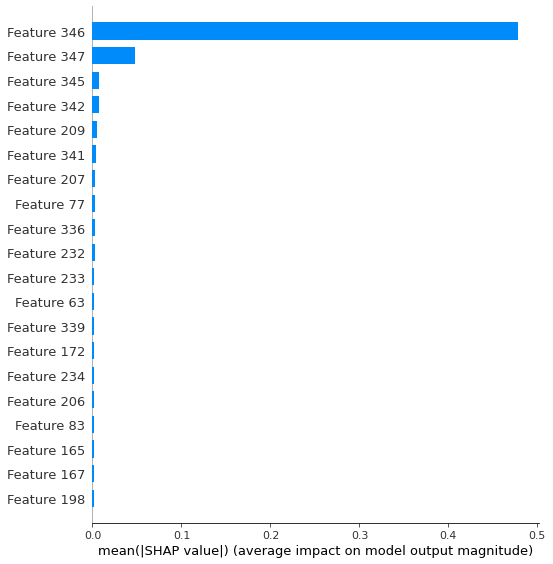

In [63]:
shap.summary_plot(shap_sigtfs_mean_resp_df.values, np.empty(shape=shap_sigtfs_mean_resp_df.shape), plot_type='bar')

## BINNING

### FEATURE BINNING DATA

In [64]:
feats_dir = '../OUTPUT/Human_chip_pert_enhanPromo500kbAgg_5primPromo2kb_CPU/all_feats/xgb/{}/feats.csv.gz'.format(all_tfs[0])

feats_bin_df = pd.read_csv(feats_dir, header=None, sep=",", names=['feat','subfeat','start','end'])
feats_bin_df

,feat,subfeat,start,end
0,tf_binding,ENSG00000162772,0,42
1,histone_modifications,K562_H3K27ac,42,84
2,histone_modifications,K562_H3K27me3,84,126
3,histone_modifications,K562_H3K36me3,126,168
4,histone_modifications,K562_H3K4me1,168,210
5,histone_modifications,K562_H3K4me3,210,252
6,histone_modifications,K562_H3K9me3,252,294
7,chromatin_accessibility,K562_atac,294,336
8,dna_sequence_nt_freq,AA,336,337
9,dna_sequence_nt_freq,AC,337,338


In [65]:
def clean_feats(feats_df):
    idxs = [0,7]
    
    # tf_binding & chrom acc
    for idx in idxs:
        feats_df.loc[idx, 'subfeat'] = feats_df.loc[idx,'feat']
        
    # dinucleotides
    dna = feats_df[feats_df['feat']=='dna_sequence_nt_freq']
    start = dna['start'].values[0]
    end = dna['end'].values[-1]
    
    idx = dna.index[0]
    
    feats_df.loc[idx] = ['dna','Dinucleotides',start,end]
    
    # GEX
    feats_df = feats_df.replace({'median_level':'GEX level', 'variation':'GEX var'})
    
    feats_df = feats_df[feats_df['feat'] != 'dna_sequence_nt_freq']
    
    feats_df = feats_df.drop(columns=['feat']).reset_index(drop=True)
    
    feats_df = feats_df.rename(columns={'subfeat':'feat'})
    
    return feats_df

def group_by_features(feat_df, grouping_df):
    
    df = pd.DataFrame()

    for idx, row in grouping_df.iterrows():

        feat = row['feat']
        start = row['start']
        end = row['end']

        col_names = ['feat{}'.format(i) for i in range(start,end)]

        # sum up respective columns
        sum_feat_col = feat_df[col_names].sum(axis=1)

        # add column to dataset
        df[feat] = sum_feat_col

        # remove columns that were summed
#         feat_df.drop(col_names)

    return df

def group_by_features_abs(feat_df, grouping_df):
    
    df = pd.DataFrame()

    for idx, row in grouping_df.iterrows():

        feat = row['feat']
        start = row['start']
        end = row['end']

        col_names = ['feat{}'.format(i) for i in range(start,end)]

        # sum up respective columns
        sum_feat_col = feat_df[col_names].abs().sum(axis=1)

        # add column to dataset
        df[feat] = sum_feat_col

        # remove columns that were summed
#         feat_df.drop(col_names)

    return df

In [66]:
# clean up feature binning df
clean_feats_bin_df = clean_feats(feats_bin_df)
clean_feats_bin_df

,feat,start,end
0,tf_binding,0,42
1,K562_H3K27ac,42,84
2,K562_H3K27me3,84,126
3,K562_H3K36me3,126,168
4,K562_H3K4me1,168,210
5,K562_H3K4me3,210,252
6,K562_H3K9me3,252,294
7,chromatin_accessibility,294,336
8,Dinucleotides,336,346
9,GEX level,346,347


In [67]:
# bin shap matrix features
shap_bin_df = group_by_features(shap_sigtfs_mean_resp_df, clean_feats_bin_df)
shap_bin_df

,tf_binding,K562_H3K27ac,K562_H3K27me3,K562_H3K36me3,K562_H3K4me1,K562_H3K4me3,K562_H3K9me3,chromatin_accessibility,Dinucleotides,GEX level,GEX var
0,3.367645e-05,0.005380,0.003578,0.003088,0.042877,-0.015067,-0.000606,0.009138,0.044503,0.159313,-0.007130
1,1.141660e-04,0.006950,-0.007093,-0.003416,0.002204,-0.018467,-0.000583,-0.001997,-0.017543,0.429059,-0.018706
2,8.923328e-05,0.009190,0.001666,0.027510,0.032554,0.021194,-0.001864,-0.001639,0.027918,0.822830,0.108526
3,1.022571e-03,-0.007343,-0.000647,-0.000458,0.063581,-0.032240,0.000301,0.005998,0.000436,0.142260,0.009074
4,1.991224e-03,0.030556,-0.001233,0.007583,0.021821,0.027930,-0.004828,0.024270,-0.012518,0.454543,0.034278
5,1.201798e-04,0.007312,0.008070,0.008735,0.037648,0.004984,0.001612,0.004103,0.113669,0.241678,0.122802
6,2.321820e-03,0.043041,-0.001438,0.007569,0.026619,0.042684,-0.000515,0.000936,0.008263,0.786628,0.065128
7,1.055437e-02,-0.007265,-0.009168,0.000700,0.027215,-0.083452,0.000851,0.006517,-0.003252,0.239254,-0.025278
8,2.349925e-03,0.003145,0.002142,0.014344,0.049999,0.004029,0.000084,0.002357,0.055196,0.593039,0.094704
9,3.811038e-03,0.013125,0.001424,0.002359,-0.005759,0.017507,-0.000176,0.002333,-0.000653,0.312664,-0.043973


In [68]:
# bin feature matrix features
feat_mtx_bin_df = group_by_features(feat_mtx_resp_df, clean_feats_bin_df)
feat_mtx_bin_df

,tf_binding,K562_H3K27ac,K562_H3K27me3,K562_H3K36me3,K562_H3K4me1,K562_H3K4me3,K562_H3K9me3,chromatin_accessibility,Dinucleotides,GEX level,GEX var
ENSG00000000419,0.00000,3369.677824,147.044924,555.439557,1729.770144,5714.498762,222.764617,763.186742,0.560684,4.805038,-0.000185
ENSG00000000460,0.00000,2340.205286,328.964048,482.234710,461.071239,2620.095921,397.181891,989.424503,0.643024,4.257006,0.001709
ENSG00000000938,0.00000,521.676828,1175.101183,404.825988,2292.767196,532.271590,400.314588,689.774968,0.581833,0.301030,-0.016554
ENSG00000000971,0.00000,806.574561,34.676044,129.325311,208.069974,415.829268,212.885477,325.603372,0.639597,4.583108,0.006452
ENSG00000001617,0.00000,527.571530,629.086806,637.595819,4612.320228,1064.876849,266.285898,876.070650,0.828842,3.415307,-0.023764
...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000280670,0.00000,1629.413785,137.745882,393.373551,989.297864,2432.838891,173.548715,887.323552,0.657875,3.792532,-0.026274
ENSG00000280789,4.03322,675.669989,23.701728,123.225335,700.293547,1101.805976,36.373057,163.623269,0.829666,4.332883,0.007087
ENSG00000281991,0.00000,106.122754,31.913311,258.002933,277.030321,43.388202,37.606281,114.593492,0.872009,2.978637,0.552656
ENSG00000282419,0.00000,32.145293,40.974258,30.024765,60.089079,25.404019,58.252695,35.409549,0.302849,0.301030,0.061091


### SUMMARY PLOT: MEAN OF SHAP VALUES FOR FEATURES -- WITH  FEATURE BINNING 

In [69]:
label_df = pd.DataFrame(columns=shap_bin_df.columns)
label_df.append(pd.DataFrame(np.empty(shape=shap_bin_df.shape), columns=shap_bin_df.columns), ignore_index=True)

,tf_binding,K562_H3K27ac,K562_H3K27me3,K562_H3K36me3,K562_H3K4me1,K562_H3K4me3,K562_H3K9me3,chromatin_accessibility,Dinucleotides,GEX level,GEX var
0,6.013470e-154,8.771425e-19,6.127435e-154,3.809862e-08,3.809826e-08,6.013470e-154,1.397369e-76,3.809826e-08,6.013470e-154,1.397369e-76,7.987590e+175
1,6.013470e-154,1.303563e-76,4.472697e+251,6.013472e-154,3.266230e-86,3.714574e-81,6.013915e-154,2.624739e-76,8.775660e-19,6.127435e-154,3.809862e-08
2,1.398043e-76,1.811501e-152,8.007516e+175,7.987590e+175,6.013470e-154,3.732473e+69,1.811501e-152,8.007516e+175,7.987590e+175,6.013470e-154,3.732473e+69
3,1.811501e-152,8.007516e+175,7.987590e+175,6.013470e-154,3.732473e+69,1.811501e-152,8.007516e+175,7.987590e+175,6.013470e-154,3.732473e+69,1.811501e-152
4,8.007516e+175,7.987590e+175,6.013470e-154,3.732473e+69,1.811501e-152,8.007516e+175,7.987590e+175,4.370823e-19,6.127435e-154,4.083777e+223,8.054832e+251
5,9.347211e-67,1.811501e-152,8.007516e+175,7.987590e+175,6.013470e-154,1.303563e-76,1.811501e-152,8.007516e+175,7.987590e+175,6.013470e-154,1.303563e-76
6,1.811501e-152,8.007516e+175,1.398043e-76,1.811501e-152,8.007516e+175,1.398043e-76,4.083746e+223,8.054832e+251,1.398043e-76,2.209037e+136,4.370823e-19
7,1.398041e-76,3.809826e-08,6.013470e-154,1.397369e-76,7.987590e+175,6.013470e-154,1.303563e-76,4.472697e+251,6.013472e-154,3.040650e-86,4.083746e+223
8,8.054832e+251,4.472763e+251,6.013472e-154,5.314996e+160,4.083746e+223,8.054832e+251,4.472763e+251,6.013472e-154,5.314996e+160,4.083746e+223,8.054832e+251
9,4.472763e+251,6.013472e-154,5.314996e+160,4.083746e+223,8.054832e+251,4.472763e+251,6.013472e-154,5.314996e+160,4.083746e+223,8.054832e+251,4.472763e+251


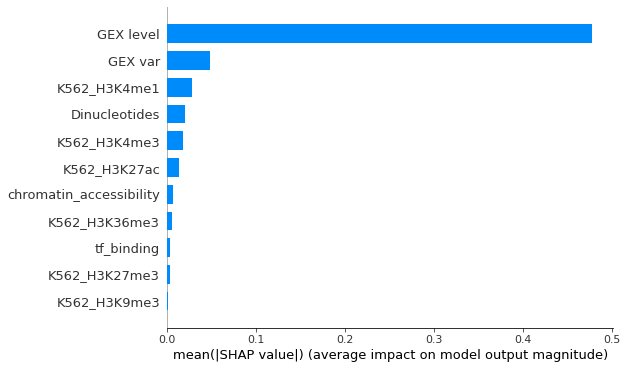

In [70]:
shap.summary_plot(shap_bin_df.values, feat_mtx_bin_df, plot_type='bar')

### PLOT: MEAN OF SHAP VALUES FOR FEATURES -- WITH FEATURE BINNING

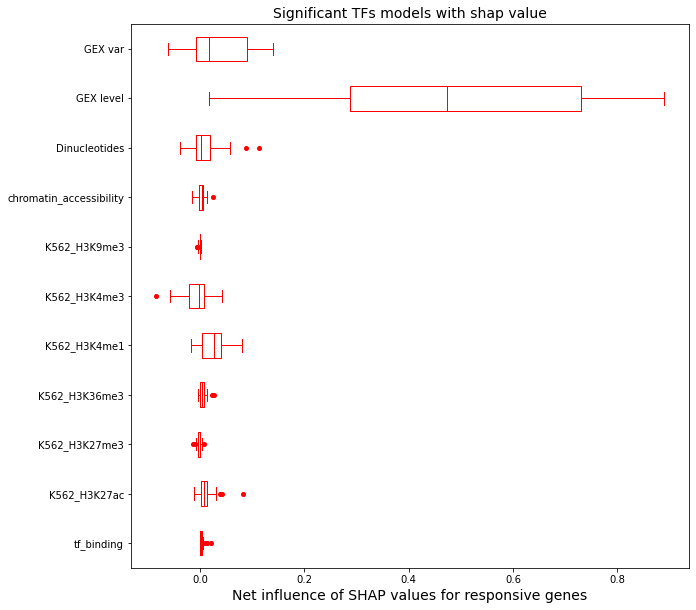

In [72]:
plt.figure(figsize=(10,10))

# flier (aka outlier properties)
flierprops = dict(marker='o', markerfacecolor='r', markersize=4,
                  linestyle='none', markeredgecolor='r')

bp = plt.boxplot(shap_bin_df.values, vert=False, labels=shap_bin_df.columns, flierprops=flierprops)

# apply color to all elements of boxplot
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='r')

# misc labels
plt.title('Significant TFs models with shap value', fontsize=14)
plt.xlabel('Net influence of SHAP values for responsive genes', fontsize=14)

plt.show()